In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Read in Data

In [2]:
train_df = pd.read_parquet('../data/curated/train_data/')
test_df = pd.read_parquet('../data/curated/test_data/')
train_df.dtypes

merchant_abn                 int64
total_num_consumer           int64
avg_dollar_value           float64
total_num_transaction        int64
mean_income                float64
revenue_level               object
total_revenue              float64
total_num_postcode           int64
tag                         object
y_total_num_consumer       float64
y_total_revenue            float64
y_total_num_transaction    float64
dtype: object

### Inspect Correlation
- categorical variables: tag, revenue level  
use anova test to examine the significance of these variables in predicting each target variable

- continuous variables  
calculate the pearson correlation of each pair of continuous variables

In [3]:
model = ols('y_total_num_consumer ~ C(tag) + C(revenue_level)', data=train_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(tag),1.057685e+09,23.0,10.876304,1.301426e-38
C(revenue_level),1.470815e+07,4.0,0.869663,4.812364e-01
Residual,1.588082e+10,3756.0,NaN,NaN


In [4]:
model = ols('y_total_revenue ~ C(tag) + C(revenue_level)', data=train_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(tag),1.351838e+14,23.0,2.344625,2.949811e-04
C(revenue_level),2.212268e+14,4.0,22.062487,5.046448e-18
Residual,9.415620e+15,3756.0,NaN,NaN


In [5]:
model = ols('y_total_num_transaction ~ C(tag) + C(revenue_level)', data=train_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(tag),2.404862e+09,23.0,5.414415,1.272785e-15
C(revenue_level),7.448319e+07,4.0,0.964245,4.258409e-01
Residual,7.253313e+10,3756.0,NaN,NaN


#### Observation
"tag" is significant in all models, whereas "revenue level" is not a significant feature in predicting total number of consumers and transactions

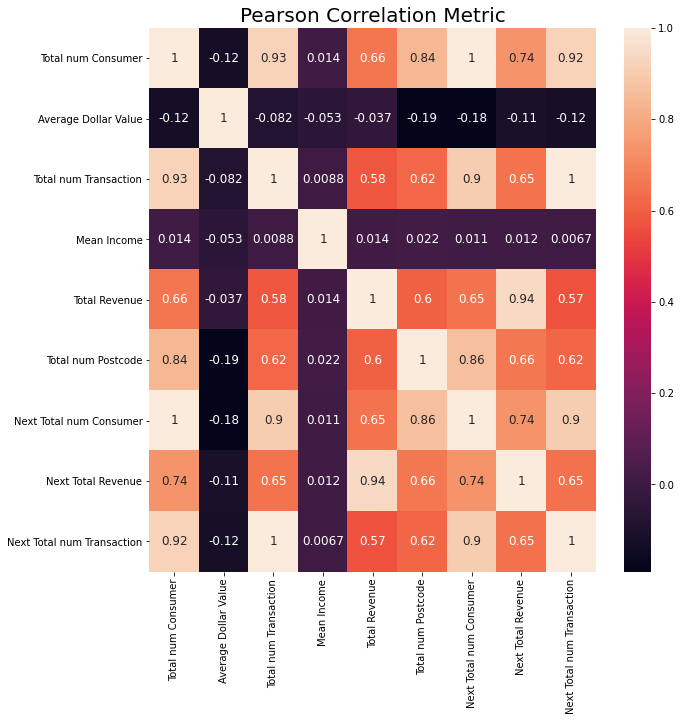

In [6]:
# pearson correlation heatmap for continuous variables
x_axis = ["Total num Consumer", "Average Dollar Value", "Total num Transaction", "Mean Income", "Total Revenue", "Total num Postcode", "Next Total num Consumer", "Next Total Revenue", "Next Total num Transaction"]
plt.figure(figsize = (10, 10))
sns.heatmap(train_df.drop('merchant_abn', axis=1).corr(), annot = True, annot_kws={"size": 12}, xticklabels=x_axis, yticklabels=x_axis)
plt.title('Pearson Correlation Metric', size = 20)
plt.savefig("../plots/Pearson Correlation Metric")

#### Observation
"Mean income" and "avergate dollar value" have little correlation with target variables. Therefore, they can be excluded in models.

### Data Preprocessing

In [7]:
# drop the columns not needed
train_df = train_df[['merchant_abn', 'total_num_consumer', 'tag', 'total_revenue', 'revenue_level', 'total_num_postcode', 
                     'total_num_transaction', 'y_total_num_consumer', 'y_total_revenue', 'y_total_num_transaction']].dropna()
train_df = train_df.set_index('merchant_abn')

test_df = test_df[['merchant_abn', 'total_num_consumer', 'tag', 'total_num_postcode', 'total_revenue',
                   'revenue_level', 'total_num_transaction']].dropna()
test_df = test_df.set_index('merchant_abn')

In [8]:
# change tags and revenue level into numeric features using one hot encoding
cat_features = ["tag", "revenue_level"]
train_df = pd.get_dummies(train_df, columns = cat_features)
test_df = pd.get_dummies(test_df, columns = cat_features)

train_df.head()

,total_num_consumer,total_revenue,total_num_postcode,total_num_transaction,y_total_num_consumer,y_total_revenue,y_total_num_transaction,tag_antique,tag_art dealer,tag_artist supply,...,tag_shoe,tag_stationery,tag_telecom,tag_tent,tag_watch,revenue_level_a,revenue_level_b,revenue_level_c,revenue_level_d,revenue_level_e
merchant_abn,,,,,,,,,,,,,,,,,,,,,
10023283211,808,30964.988492,719,823,980.0,38940.291409,1002.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10142254217,731,130143.715472,642,750,918.0,154467.920919,925.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10187291046,87,31795.597893,87,87,99.0,41683.211213,100.0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
10192359162,107,305563.802544,107,107,107.0,290071.006235,107.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10206519221,2244,589149.860698,1619,2370,2662.0,666766.406705,2811.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Models for Total Number of Consumers

### Linear Regression

In [9]:
labels = ['y_total_num_consumer', 'y_total_revenue', 'y_total_num_transaction']
# select useful features (exclude revenue_level)
features = [i for i in train_df.columns if i not in labels and not i.startswith('revenue')]
X = train_df[features]
y = train_df['y_total_num_consumer']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lr = LinearRegression()
fitted_model = lr.fit(X_train, y_train)
print("accuracy:", fitted_model.score(X_test, y_test))
print("Intercept: %s" % str(fitted_model.intercept_))
coef = pd.DataFrame({"feature":features,"coefficient":lr.coef_})
coef.head(10)

accuracy: 0.9993581595579886
Intercept: -10.244642740304812


,feature,coefficient
0,total_num_consumer,1.211250
1,total_revenue,-0.000025
2,total_num_postcode,0.091765
3,total_num_transaction,-0.064821
4,tag_antique,-0.491069
5,tag_art dealer,-23.258787
6,tag_artist supply,7.093019
7,tag_bicycle,-2.883267
8,tag_books,15.336519
9,tag_cable,-1.293609


In [11]:
y_pred = fitted_model.predict(X_test)
result = pd.DataFrame({'predicted_total_num_consumer': y_pred, 'true_total_num_consumer': y_test})
result

,predicted_total_num_consumer,true_total_num_consumer
merchant_abn,,
22629400849,33.930346,37.0
22470136913,1299.563637,1223.0
62363832078,87.605440,57.0
77421432003,75.012366,72.0
28034382339,-0.805308,5.0
...,...,...
60072023557,45.012484,39.0
22526511302,1437.147106,1419.0
56946407125,6890.376438,6792.0


In [22]:
result.loc[result['predicted_total_num_consumer']<=0]

,predicted_total_num_consumer,true_total_num_consumer
merchant_abn,,
28034382339,-0.805308,5.0
66236596240,-23.967758,3.0
21073645356,-4.113245,1.0
97217894162,-13.797227,1.0
35381098677,-3.023958,10.0
...,...,...
29745128769,-23.268785,17.0
48699038894,-19.937713,1.0
26763947687,-24.373967,2.0


In [12]:
print("r2 score:", r2_score(y_pred, y_test))
print("Mean Absolute Error:", mean_absolute_error(y_pred, y_test))

r2 score: 0.9993556767397489
Mean Absolute Error: 28.859354170933873


In [13]:
# mean evaluation metrics of 10 fold CV
scores = cross_validate(lr, X, y, cv=10, scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
print("train r2 score: %0.4f" % scores['train_r2'].mean())
print("test r2 score: %0.4f" % scores['test_r2'].mean())
print("train mean absolute error:: %0.4f" % -scores['train_neg_mean_absolute_error'].mean())
print("test mean absolute error:: %0.4f" % -scores['test_neg_mean_absolute_error'].mean())

train r2 score: 0.9994
test r2 score: 0.9993
train mean absolute error:: 29.5705
test mean absolute error:: 29.9603


### Neural Network

In [14]:
# scale train and test dataset in order to be standard normally distributed with zero mean
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)
X_trainscaled.shape, X_testscaled.shape

((2648, 28), (1136, 28))

In [15]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(128,128,128,128),activation="relu" ,solver = 'adam', random_state=30034, max_iter=20000)\
    .fit(X_trainscaled, y_train)
y_pred = mlp_reg.predict(X_testscaled)

In [16]:
df_result = pd.DataFrame({'y_pred': y_pred, 'y_true': y_test})
df_result

,y_pred,y_true
merchant_abn,,
22629400849,28.513847,37.0
22470136913,1255.658393,1223.0
62363832078,16.542629,57.0
77421432003,52.738243,72.0
28034382339,2.051842,5.0
...,...,...
60072023557,38.032341,39.0
22526511302,1421.553458,1419.0
56946407125,6811.289065,6792.0


In [17]:
print('r2 score:', r2_score(y_pred, y_test))
print('mean absolute error:', mean_absolute_error(y_pred, y_test))

r2 score: 0.9983987014118632
mean absolute error: 37.12639237862994


### Predict on Test Set

In [18]:
lr = LinearRegression()
fitted_model = lr.fit(X, y)
y_test = test_df[features]
y_pred = fitted_model.predict(y_test)
y_test['y_pred_total_num_consumer'] = y_pred
y_test

<ipython-input-18-cbad1caba63c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['y_pred_total_num_consumer'] = y_pred


,total_num_consumer,total_revenue,total_num_postcode,total_num_transaction,tag_antique,tag_art dealer,tag_artist supply,tag_bicycle,tag_books,tag_cable,...,tag_jewelry,tag_motor,tag_music,tag_opticians,tag_shoe,tag_stationery,tag_telecom,tag_tent,tag_watch,y_pred_total_num_consumer
merchant_abn,,,,,,,,,,,,,,,,,,,,,
10023283211,1765,7.119790e+04,1357,1837,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2131.143386
10142254217,1582,2.766417e+05,1242,1647,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1904.682106
10187291046,195,7.401446e+04,192,195,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,232.439735
10192359162,216,6.222523e+05,208,216,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,243.700159
10206519221,4814,1.325206e+06,2486,5393,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5679.090531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99938978285,8012,1.348104e+06,2918,9744,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,9310.360959
99974311662,76,6.666324e+04,74,76,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,97.297453
99976658299,10216,1.309766e+07,3061,13309,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,11453.366640


In [19]:
result_df = y_test['y_pred_total_num_consumer'].reset_index()
result_df.loc[result_df['y_pred_total_num_consumer']<=0] # how to handle negative consumer count?
# result_df.to_csv('../data/curated/pred_total_num_consumer.csv', index=False)

,merchant_abn,y_pred_total_num_consumer
10,10346855916,-17.138063
16,10441711491,-5.498501
23,10596295795,-10.157497
29,10739268011,-29.365062
48,11149063370,-30.271870
...,...,...
3943,99358609752,-2.765571
3946,99420575685,-27.491031
3954,99776743787,-28.645263
3955,99785979138,-26.539946


## Models for Total Number of Transactions


### Linear Regression

In [20]:
labels = ['y_total_num_consumer', 'y_total_revenue', 'y_total_num_transaction']
# select useful features (exclude revenue_level)
features = [i for i in train_df.columns if i not in labels and not i.startswith('revenue')]
X = train_df[features]
y = train_df['y_total_num_transaction']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lr = LinearRegression()
fitted_model = lr.fit(X_train, y_train)
print("accuracy:", fitted_model.score(X_test, y_test))
print("Intercept: %s" % str(fitted_model.intercept_))
coef = pd.DataFrame({"feature":features,"coefficient":lr.coef_})
coef.head(10)

accuracy: 0.9998576018307352
Intercept: -4.877926651746293


,feature,coefficient
0,total_num_consumer,0.017500
1,total_revenue,-0.000024
2,total_num_postcode,-0.021817
3,total_num_transaction,1.207242
4,tag_antique,-0.260103
5,tag_art dealer,-27.938006
6,tag_artist supply,11.094473
7,tag_bicycle,-3.718743
8,tag_books,16.894263
9,tag_cable,5.239985


In [25]:
y_pred = fitted_model.predict(X_test)
result = pd.DataFrame({'predicted_total_num_transaction': y_pred, 'true_total_num_transaction': y_test})
result

,predicted_total_num_transaction,true_total_num_transaction
merchant_abn,,
22629400849,40.864498,37.0
22470136913,1317.192720,1249.0
62363832078,91.252037,57.0
77421432003,78.295774,72.0
28034382339,8.498722,5.0
...,...,...
60072023557,51.632240,39.0
22526511302,1463.336258,1461.0
56946407125,8096.963670,8011.0


In [27]:
result.loc[result['predicted_total_num_transaction']<=0]

,predicted_total_num_transaction,true_total_num_transaction
merchant_abn,,
66236596240,-27.192663,3.0
21073645356,-4.005122,1.0
97217894162,-7.612798,1.0
88299699256,-20.180985,7.0
51267358936,-4.342746,2.0
...,...,...
29745128769,-26.502428,17.0
48699038894,-18.618990,1.0
26763947687,-23.210175,2.0


In [28]:
print("r2 score:", r2_score(y_pred, y_test))
print("Mean Absolute Error:", mean_absolute_error(y_pred, y_test))

r2 score: 0.9998576469449257
Mean Absolute Error: 30.8421450449685


In [29]:
# mean evaluation metrics of 10 fold CV
scores = cross_validate(lr, X, y, cv=10, scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
print("train r2 score: %0.4f" % scores['train_r2'].mean())
print("test r2 score: %0.4f" % scores['test_r2'].mean())
print("train mean absolute error:: %0.4f" % -scores['train_neg_mean_absolute_error'].mean())
print("test mean absolute error:: %0.4f" % -scores['test_neg_mean_absolute_error'].mean())

train r2 score: 0.9998
test r2 score: 0.9997
train mean absolute error:: 31.6244
test mean absolute error:: 32.0770


### Neural Network

In [31]:
# scale train and test dataset in order to be standard normally distributed with zero mean
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)

mlp_reg = MLPRegressor(hidden_layer_sizes=(128,128,128,128),activation="relu" ,solver = 'adam', random_state=30034, max_iter=20000)\
    .fit(X_trainscaled, y_train)
y_pred = mlp_reg.predict(X_testscaled)
print('r2 score:', r2_score(y_pred, y_test))
print('mean absolute error:', mean_absolute_error(y_pred, y_test))

df_result = pd.DataFrame({'predicted_total_num_transaction': y_pred, 'true_total_num_transaction': y_test})
df_result


r2 score: 0.9993256940296626
mean absolute error: 41.49882734811618


,predicted_total_num_transaction,true_total_num_transaction
merchant_abn,,
22629400849,59.481466,37.0
22470136913,1391.775092,1249.0
62363832078,82.483007,57.0
77421432003,82.325520,72.0
28034382339,26.793526,5.0
...,...,...
60072023557,66.666885,39.0
22526511302,1573.585383,1461.0
56946407125,8153.506931,8011.0


## Model for BNPL Revenue

### Linear Regression

In [33]:
# select useful features 
features = [i for i in train_df.columns if i not in labels]
X = train_df[features]
y = train_df['y_total_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lr = LinearRegression()
fitted_model = lr.fit(X_train, y_train)
print("accuracy:", fitted_model.score(X_test, y_test))
print("Intercept: %s" % str(fitted_model.intercept_))
coef = pd.DataFrame({"feature":features,"coefficient":lr.coef_})
coef.head(10)


accuracy: 0.9288093457564308
Intercept: -87822.62248173764


,feature,coefficient
0,total_num_consumer,285.058256
1,total_revenue,0.865958
2,total_num_postcode,-104.056548
3,total_num_transaction,-46.306307
4,tag_antique,-66117.640838
5,tag_art dealer,-246208.280110
6,tag_artist supply,143615.413073
7,tag_bicycle,-28505.146137
8,tag_books,188888.393114
9,tag_cable,48290.378139


In [36]:
y_pred = fitted_model.predict(X_test)
result = pd.DataFrame({'predicted_total_revenue': y_pred, 'true_total_revenue': y_test})
result

,predicted_total_revenue,true_total_revenue
merchant_abn,,
22629400849,1.070102e+05,4.484151e+04
22470136913,5.839733e+05,6.792839e+05
62363832078,1.145343e+06,3.055751e+05
77421432003,-1.032556e+05,3.627599e+04
28034382339,5.458361e+04,1.268942e+04
...,...,...
60072023557,1.103627e+05,3.312711e+04
22526511302,1.959274e+06,2.262301e+06
56946407125,2.513121e+06,1.783839e+06


In [37]:
print("r2 score:", r2_score(y_pred, y_test))
print("Mean Absolute Error:", mean_absolute_error(y_pred, y_test))

r2 score: 0.9207678371976615
Mean Absolute Error: 184375.80712365295


In [38]:
# mean evaluation metrics of 10 fold CV
scores = cross_validate(lr, X, y, cv=10, scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
print("train r2 score: %0.4f" % scores['train_r2'].mean())
print("test r2 score: %0.4f" % scores['test_r2'].mean())
print("train mean absolute error:: %0.4f" % -scores['train_neg_mean_absolute_error'].mean())
print("test mean absolute error:: %0.4f" % -scores['test_neg_mean_absolute_error'].mean())

train r2 score: 0.9216
test r2 score: 0.9086
train mean absolute error:: 183258.1835
test mean absolute error:: 186302.4063


### Neural Network

In [50]:
# select useful features 
features = [i for i in train_df.columns if i not in labels]
X = train_df[features]
y = train_df['y_total_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [51]:
# scale train and test dataset in order to be standard normally distributed with zero mean
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)
X_trainscaled.shape, X_testscaled.shape

((2648, 33), (1136, 33))

In [55]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(128,128,128,128),activation="relu" ,solver = 'adam', random_state=0, max_iter=20000)\
    .fit(X_trainscaled, y_train)
y_pred = mlp_reg.predict(X_testscaled)

In [56]:
df_result = pd.DataFrame({'predicted_total_revenue': y_pred, 'true_total_revenue': y_test})
df_result

,predicted_total_revenue,true_total_revenue
merchant_abn,,
22629400849,1.490068e+04,4.484151e+04
22470136913,7.186189e+05,6.792839e+05
62363832078,4.055962e+05,3.055751e+05
77421432003,1.463052e+04,3.627599e+04
28034382339,2.135145e+04,1.268942e+04
...,...,...
60072023557,1.871324e+04,3.312711e+04
22526511302,2.258894e+06,2.262301e+06
56946407125,1.677045e+06,1.783839e+06


In [57]:
print('r2 score:', r2_score(y_pred, y_test))
print('mean absolute error:', mean_absolute_error(y_pred, y_test))

r2 score: 0.9785257106815817
mean absolute error: 63977.50446117643
